# Explore UR5e table data

## Init

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.auto import tqdm

In [2]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore

In [3]:
from rosbags.highlevel import AnyReader

In [5]:
from PIL import Image
import cv2

## Get data

In [6]:
data_path = Path("../table-task-ur5e")
data_path.exists()

True

In [7]:
bagfiles = list(data_path.glob("*.bag"))
bagfiles

[PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [8]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [9]:
def extract_eef_tf_data_from_rosbag(bagfile):
    tf = {"x": [], "y": [], "z": [], "timestamp": []}
    
    # Create a type store to use if the bag has no message definitions.
    typestore = get_typestore(Stores.ROS1_NOETIC)
    
    # Create reader instance and open for reading.
    with AnyReader([bagfile], default_typestore=typestore) as reader:
        connections = [x for x in reader.connections if x.topic == '/imu_raw/Imu']
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            # print(msg.header.frame_id
            if connection.msgtype == "tf2_msgs/msg/TFMessage":
                if msg.transforms[0].child_frame_id == "tool0_controller" and msg.transforms[0].header.frame_id == "base":
                    tf["x"].append(msg.transforms[0].transform.translation.x)
                    tf["y"].append(msg.transforms[0].transform.translation.y)
                    tf["z"].append(msg.transforms[0].transform.translation.z)
                    # tf["timestamp"].append(pd.to_datetime(timestamp, utc=True).tz_localize("UTC").tz_convert("EST"))
                    tf["timestamp"].append(pd.to_datetime(timestamp, utc=True).tz_convert("EST"))
    
    tf_df = pd.DataFrame(tf)
    return tf_df

In [10]:
tf_df = extract_eef_tf_data_from_rosbag(bagfile)
tf_df

,x,y,z,timestamp
0,-0.057518,-0.349367,0.245931,2025-09-08 18:46:19.428560717-05:00
1,-0.057518,-0.349359,0.245916,2025-09-08 18:46:19.430824291-05:00
2,-0.057527,-0.349371,0.245943,2025-09-08 18:46:19.432620296-05:00
3,-0.057521,-0.349371,0.245940,2025-09-08 18:46:19.434438816-05:00
4,-0.057525,-0.349373,0.245945,2025-09-08 18:46:19.436862995-05:00
...,...,...,...,...
57562,-0.079063,-0.339990,0.226383,2025-09-08 18:48:14.634462638-05:00
57563,-0.079040,-0.339984,0.226385,2025-09-08 18:48:14.636379567-05:00
57564,-0.079073,-0.339983,0.226388,2025-09-08 18:48:14.638744970-05:00
57565,-0.079063,-0.339978,0.226381,2025-09-08 18:48:14.640788775-05:00


## Other data type + webcam data

In [11]:
# Create a typestore for the matching ROS release.
typestore = get_typestore(Stores.ROS1_NOETIC)

# Create reader instance and open for reading.
with Reader(bagfile) as reader:
    # Topic and msgtype information is available on .connections list.
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

    # Iterate over messages.
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/imu_raw/Imu':
            msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
            print(msg.header.frame_id)

    # # The .messages() method accepts connection filters.
    # connections = [x for x in reader.connections if x.topic == '/imu_raw/Imu']
    # for connection, timestamp, rawdata in reader.messages(connections=connections):
    #     msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
    #     print(msg.header.frame_id)

/tf tf2_msgs/msg/TFMessage
/joint_states sensor_msgs/msg/JointState
/gripper_data/position ur5e_move/msg/gripper_pos
/tf tf2_msgs/msg/TFMessage
/camera/image sensor_msgs/msg/Image


In [12]:
# Create a type store to use if the bag has no message definitions.
typestore = get_typestore(Stores.ROS1_NOETIC)

# Create reader instance and open for reading.
with AnyReader([bagfile], default_typestore=typestore) as reader:
    connections = [x for x in reader.connections if x.topic == '/imu_raw/Imu']
    for connection, timestamp, rawdata in reader.messages(connections=connections):
        msg = reader.deserialize(rawdata, connection.msgtype)
        # print(msg.header.frame_id
        if connection.msgtype == "sensor_msgs/msg/Image":
            print(msg)
            break

sensor_msgs__msg__Image(header=std_msgs__msg__Header(seq=1252, stamp=builtin_interfaces__msg__Time(sec=0, nanosec=0, __msgtype__='builtin_interfaces/msg/Time'), frame_id='', __msgtype__='std_msgs/msg/Header'), height=480, width=640, encoding='bgr8', is_bigendian=0, step=1920, data=array([ 14,  28,  80, ...,  60,  91, 188], shape=(921600,), dtype=uint8), __msgtype__='sensor_msgs/msg/Image')


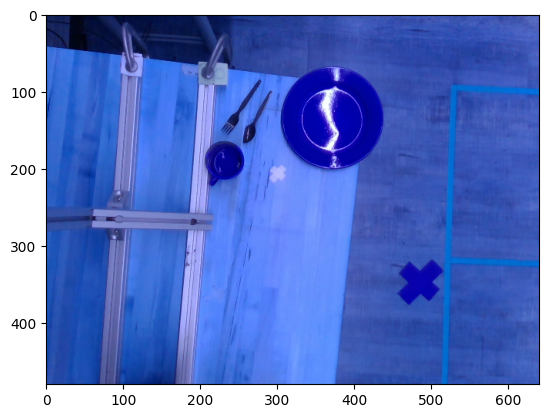

In [13]:
img_arr = msg.data.reshape((msg.height, msg.width, 3))
img = Image.fromarray(img_arr)
plt.imshow(img)
plt.show()

In [14]:
extension = "mkv"
video_path = bagfile.parent / (bagfile.stem + "." + extension)
video_path

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.mkv')

In [15]:
# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Use 'mp4v' for MP4 format
video = cv2.VideoWriter(video_path, fourcc, 20, (msg.width, msg.height))

# Create a type store to use if the bag has no message definitions.
typestore = get_typestore(Stores.ROS1_NOETIC)

# Create reader instance and open for reading.
with AnyReader([bagfile], default_typestore=typestore) as reader:
    connections = [x for x in reader.connections if x.topic == '/imu_raw/Imu']
    for connection, timestamp, rawdata in reader.messages(connections=connections):
        msg = reader.deserialize(rawdata, connection.msgtype)
        # print(msg.header.frame_id
        if connection.msgtype == "sensor_msgs/msg/Image":
            frame = msg.data.reshape((msg.height, msg.width, 3))
            # img = Image.fromarray(img_arr)
            # Add images to the video
            video.write(frame)

# Release the video writer
video.release()
cv2.destroyAllWindows()

## Plot data

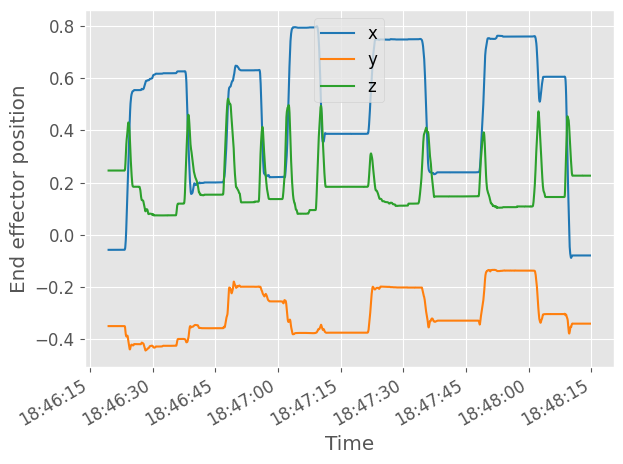

In [16]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors
    ax.plot(tf_df.timestamp, tf_df.x, label="x", color=cmap[0])
    ax.plot(tf_df.timestamp, tf_df.y, label="y", color=cmap[1])
    ax.plot(tf_df.timestamp, tf_df.z, label="z", color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Plot all demos

  0%|          | 0/10 [00:00<?, ?it/s]

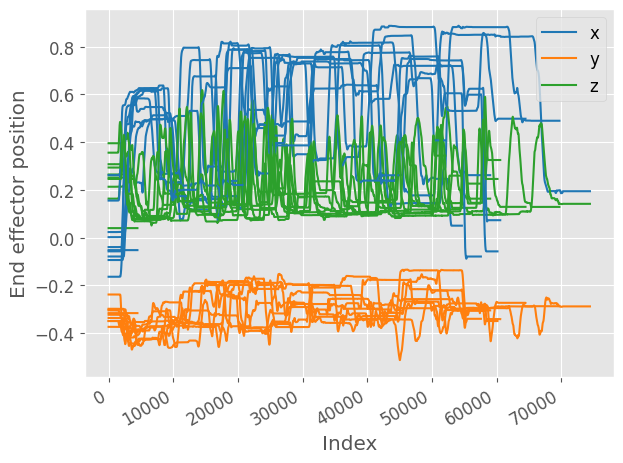

In [17]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    for idx, bagfile in enumerate(tqdm(bagfiles)):
        tf_df = extract_eef_tf_data_from_rosbag(bagfile)
        if idx == 0:
            ax.plot(tf_df.index, tf_df.x, label="x", color=cmap[0])
            ax.plot(tf_df.index, tf_df.y, label="y", color=cmap[1])
            ax.plot(tf_df.index, tf_df.z, label="z", color=cmap[2])
        else:
            ax.plot(tf_df.index, tf_df.x, color=cmap[0])
            ax.plot(tf_df.index, tf_df.y, color=cmap[1])
            ax.plot(tf_df.index, tf_df.z, color=cmap[2])
    
    ax.set_xlabel("Index")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()